In [2]:
import os
os.chdir('..')

In [3]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from xgboost import XGBRegressor
import pandas as pd
import itertools
import scipy.stats as st
import faiss
import pickle as pkl

from src.elegant_fuzzy_genetic_algorithms.helpers.generalized_param_inferrer import GeneralizedParamInferencer
from src.common.approximation_helpers import generate_search_space, init_param_index
from src.elegant_fuzzy_genetic_algorithms.param_diff_simulation import simulation_param_diff
from src.common.fitness import (griewank, schwefel, ackley, rastrigin)
from src.common.scales import scales



In [4]:
gpi = GeneralizedParamInferencer(n_terms=3)

In [5]:
search_space = generate_search_space((20, 200, 20), [(.1,.5), 
                                           (0.016547844920411454, 0.972623828244773), 
                                           (0.016547844920411454, 0.972623828244773)])

In [41]:
y = [gpi.infer(*search_space[i]) for i in tqdm(range(search_space.shape[0]))]

100%|██████████| 80000/80000 [17:12<00:00, 77.49it/s] 


In [43]:
with open('y.pkl', 'wb') as f:
    pkl.dump(y, f)

In [6]:
with open('y.pkl', 'rb') as f:
    y = pkl.load(f)

In [44]:
len(y)

80000

In [13]:
y

[{'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.19894584467513501},
 {'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.19894584467513501},
 {'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.19894584467513501},
 {'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.19894584467513501},
 {'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.19894584467513501},
 {'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.19894584467513501},
 {'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.19894584467513501},
 {'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.19894584467513501},
 {'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.19894584467513501},
 {'xRate': 0.5215685126726947,
  'mRate': 0.010130709389391285,
  'subPopSize': 0.

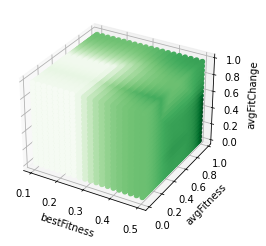

In [7]:
y_xrate = np.array(list(map(lambda x: x['xRate'], y)))
ax = plt.axes(projection='3d')
ax.scatter3D(search_space[:, 0], search_space[:, 1],search_space[:, 2], c= y_xrate,cmap='Greens')
ax.set_xlabel('bestFitness')
ax.set_ylabel('avgFitness')
ax.set_zlabel('avgFitChange')
plt.show()

In [8]:
mlpr = XGBRegressor(n_estimators=10000).fit(search_space, y_xrate)

In [9]:
mlpr.feature_importances_

array([0.2616307 , 0.53887856, 0.19949073], dtype=float32)

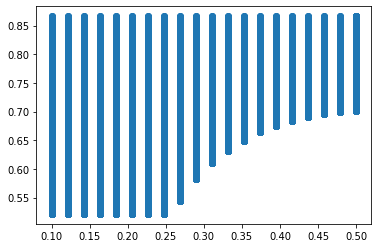

In [10]:
plt.scatter(search_space[:, 0], y_xrate)

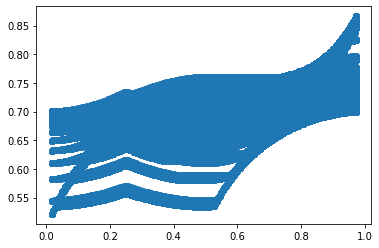

In [11]:
plt.scatter(search_space[:, 1], y_xrate)

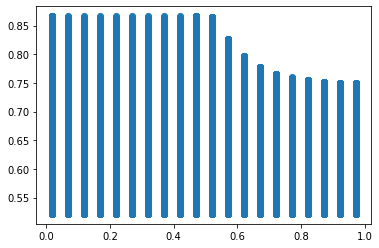

In [12]:
plt.scatter(search_space[:, 2], y_xrate)

In [13]:
N = 2000
np.random.seed(1)
test_set = np.vstack([np.random.uniform(.1, .5, N), 
                      np.random.uniform(.01,.97, N), 
                    np.random.uniform(.01, .97, N), 
                      ]).T
test_set

array([[0.2668088 , 0.56389873, 0.35449219],
       [0.3881298 , 0.85037319, 0.63760141],
       [0.10004575, 0.59422282, 0.55392775],
       ...,
       [0.43149314, 0.08050256, 0.03514338],
       [0.11239918, 0.56654757, 0.92279487],
       [0.47869131, 0.71417634, 0.55712094]])

In [14]:
param_index = init_param_index(search_space)

In [53]:
y_actual = [gpi.infer(*test_set[i]) for i in tqdm(range(test_set.shape[0]))]

100%|██████████| 2000/2000 [00:29<00:00, 68.82it/s]


In [54]:
with open('y_actual.pkl', 'wb') as f:
    pkl.dump(y_actual, f)

In [15]:
with open('y_actual.pkl', 'rb') as f:
    y_actual = pkl.load(f)

In [16]:
%%timeit
D, I = param_index.search(test_set, k=1)
y_pred = pd.DataFrame(list(itertools.chain(*np.array(y)[I].tolist())))
diff_df = y_pred - pd.DataFrame.from_records(y_actual)

884 ms ± 349 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
D, I = param_index.search(test_set, k=1)
y_pred = pd.DataFrame(list(itertools.chain(*np.array(y)[I].tolist())))
diff_df = y_pred - pd.DataFrame.from_records(y_actual)

In [18]:
for col in diff_df.columns:
    diff_df[col] = np.abs(diff_df[col])
    diff_arr = diff_df[col]
    conf_int = st.t.interval(alpha=0.95, df=len(diff_arr)-1, loc=np.mean(diff_arr), scale=st.sem(diff_arr)) 
    print(col, conf_int)

    

xRate (0.0016603763671230783, 0.0018668574795970565)
mRate (0.0001383646972602564, 0.00015557145663308797)
subPopSize (0.00042335561045013693, 0.00046418855417058646)


In [19]:
quantizer = faiss.IndexFlatL2(3) 
index = faiss.IndexIVFFlat(quantizer, 3, 100)
index.train(search_space)
index.add(search_space)


In [20]:
%%timeit
D, I = index.search(test_set[[0], :], k=1)

44.5 µs ± 921 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%%timeit
D, I = param_index.search(test_set[[0], :], k=1)

2.56 ms ± 45.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [61]:
D, I = index.search(test_set, k=1)
y_pred = pd.DataFrame(list(itertools.chain(*np.array(y)[I].tolist())))
diff_df = y_pred - pd.DataFrame.from_records(y_actual)

In [62]:
for col in diff_df.columns:
    diff_df[col] = np.abs(diff_df[col])
    diff_arr = diff_df[col]
    conf_int = st.t.interval(alpha=0.95, df=len(diff_arr)-1, loc=np.mean(diff_arr), scale=st.sem(diff_arr)) 
    print(col, conf_int)

xRate (0.0017466587227303754, 0.001970224974103544)
mRate (0.0001455548935608641, 0.00016418541450862815)
subPopSize (0.000445775560992536, 0.0004896338078240927)


In [37]:
priorities = []

for fn in [griewank, schwefel, rastrigin, ackley]:
    fn_name = fn.__name__
    priorities_ = simulation_param_diff(N=100, epochs=200, fitness_fn=fn, population_scale=scales[fn_name][0], 
                      mutation_scale=scales[fn_name][1], seed=1)
    priorities.append(priorities_)

priorities_df = list(itertools.chain(*priorities))
priorities_df = pd.DataFrame(priorities_df)

100%|██████████| 200/200 [00:03<00:00, 54.36it/s]


In [38]:
param_chg = np.vstack([np.diff(pd.DataFrame(priorities[i])[['xRate', 'mRate', 'subPopSize']].to_numpy(), axis=0) for i in range(len(priorities))])

In [64]:
keys = list(priorities[0][0].keys())[:3]

for i in range(len(keys)):
    param_stats = np.abs(param_chg[:, i])
    conf_int = st.t.interval(alpha=0.95, df=len(param_stats)-1, loc=np.mean(param_stats), scale=st.sem(param_stats)) 
    print(f'{keys[i]=}, {conf_int=}')

keys[i]='xRate', conf_int=(0.0010480190433324948, 0.0013090614472372334)
keys[i]='mRate', conf_int=(8.733492027770745e-05, 0.00010908845393643577)
keys[i]='subPopSize', conf_int=(7.0857761053587e-05, 9.843435710761442e-05)


In [22]:
y_xgboost = mlpr.predict(test_set)

In [32]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

median_absolute_error(y_xgboost, 
                    np.array(list(map(lambda x: x['xRate'], y_actual)))) * 1000

1.0669055080076428

In [24]:
y_actual

[{'xRate': 0.7025297234700626,
  'mRate': 0.025210810289171853,
  'subPopSize': 0.18319149718647962},
 {'xRate': 0.7582226804448742,
  'mRate': 0.029851890037072858,
  'subPopSize': 0.21083834814177518},
 {'xRate': 0.7033487024844564,
  'mRate': 0.025279058540371328,
  'subPopSize': 0.18341510319021348},
 {'xRate': 0.6647652642121852,
  'mRate': 0.022063772017682084,
  'subPopSize': 0.18569054847692346},
 {'xRate': 0.6155582429003452,
  'mRate': 0.017963186908362103,
  'subPopSize': 0.1934012112045577},
 {'xRate': 0.7002921852030167,
  'mRate': 0.025024348766918034,
  'subPopSize': 0.18136421761540045},
 {'xRate': 0.8231213842967682,
  'mRate': 0.03526011535806404,
  'subPopSize': 0.2147266740547197},
 {'xRate': 0.6397950645844851,
  'mRate': 0.019982922048707046,
  'subPopSize': 0.1893802296742363},
 {'xRate': 0.7001758985580948,
  'mRate': 0.025014658213174563,
  'subPopSize': 0.18011310919534707},
 {'xRate': 0.6956152754456241,
  'mRate': 0.02463460628713531,
  'subPopSize': 0.18749

In [33]:
faiss.write_index(index, './indices/params_approx.index')

In [34]:
keys_to_dump = list(y[0].keys())
for k in keys_to_dump:
    y_param = list(map(lambda x: x[k], y))
    filename = './indices/xgb_{k}_y_approx.pkl'

['xRate', 'mRate', 'subPopSize']